## consider dim

In [1]:
# ==================
# library
# ==================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
%matplotlib inline
pd.set_option('display.max_columns', 300)

In [2]:
data = '../datasets/'
out_dir = '../output/'
TRAIN_PATH = data+"train.csv"
TEST_PATH = data+ 'test.csv'
SUB_PATH = data + 'atmacup10__sample_submission.csv'
SAVE_TEST_SUB_PATH = out_dir + "sub.csv"

In [3]:
# ===============
# Settings
# ===============

SEED = 0
N_SPLITS = 5
SHUFFLE = True
LGBM_PARAMS = {'num_leaves': 32,
               'min_data_in_leaf': 64,
               'objective': 'regression',
               'max_depth': -1,
               'learning_rate': 0.05,
               "boosting": "gbdt",
               "bagging_freq": 1,
               "bagging_fraction": 0.8,
               "bagging_seed": SEED,
               "verbosity": -1,
              'reg_alpha': 0.1,
              'reg_lambda': 0.3,
              'colsample_bytree': 0.7,
              'metric':"rmse",
              'num_threads':6,
         }

LGBM_FIT_PARAMS = {
    'num_boost_round': 10000,
    'early_stopping_rounds': 200,
    'verbose_eval': 200,
}



In [4]:
# =====================
# Function
# =====================
def train_lgbm(X_train, y_train, X_valid, y_valid, X_test, categorical_features, feature_name, fold_id,lgb_params, fit_params, loss_func, calc_importances=True):
    
    train_df = lgb.Dataset(X_train, y_train,
                        categorical_feature=categorical_features,
                        feature_name=feature_name)
    if X_valid is not None:
        valid = lgb.Dataset(X_valid, y_valid,
                            categorical_feature=categorical_features,
                            feature_name=feature_name)
   
    if X_valid is not None:
        model = lgb.train(
            lgb_params,
            train_df,
            valid_sets=[train_df,valid],
            **fit_params
        )
    else:
        model = lgb.train(
            lgb_params,
            train_df,
            **fit_params
        )
    
    # train score
    if X_valid is not None:
        y_pred_valid = model.predict(X_valid)
        valid_loss = loss_func(y_valid, y_pred_valid)
    else:
        y_pred_valid = None
        valid_loss = None
    
    #test
    if X_test is not None:
        y_pred_test = model.predict(X_test)
    else:
        y_pred_test = None

    if calc_importances:
        importances = pd.DataFrame()
        importances['feature'] = feature_name
        importances['gain'] = model.feature_importance(importance_type='gain')
        importances['split'] = model.feature_importance(importance_type='split')
        importances['fold'] = fold_id
    else:
        importances = None

    return y_pred_valid, y_pred_test, valid_loss, importances, model.best_iteration

def calc_loss(y_true, y_pred):
    return  np.sqrt(mean_squared_error(y_true, y_pred))
def get_dim(df):
    df['dim'] = ''
#     df[df['sub_title'].isnull()] = '0'
    df['dim'] = df['sub_title'].str.count('×')
#     for i in range(len(df)):
#         df['dim'][i] = df['sub_title'][i].count('×')+1
#     df['dim'] = df['dim'].astype(int)
    return df
def get_collection(df, collections):
    obj_collection_df = pd.read_csv('../datasets/object_collection.csv')
    df ['has_collection'] = df['object_id'].isin(obj_collection_df['object_id'])*1
    for collect in collections:
        print(collect)
        df['has_'+collect] = ''
        df['has_'+collect] = df['object_id'].isin(obj_collection_df['object_id'][obj_collection_df['name'] == collect])*1
    return df
def has_description(df):
    df['has_description'] = ''
    df['has_description'] = ~df['description'].isnull()*1
    return df
def concat_material(df):
    material = pd.read_csv('../datasets/material.csv')
    cross_material = pd.crosstab(material['object_id'], material['name'])
    df = df.merge(cross_material, on = 'object_id',how='left' )
    return df, cross_material.columns

In [5]:
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)
len_train = len(train_df)
y = np.log1p(train_df["likes"])

In [6]:
collections = ['paintings','prints']
train_df = get_collection(train_df,collections)
test_df = get_collection(test_df,collections)

paintings
prints
paintings
prints


In [7]:
train_df = get_dim(train_df)
test_df = get_dim(test_df)

In [8]:
train_df = has_description(train_df)
test_df = has_description(test_df)

In [9]:
train_df,_= concat_material(train_df)
test_df, material_col = concat_material(test_df)

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12026 entries, 0 to 12025
Columns: 101 entries, object_id to wood board
dtypes: float64(81), int64(6), object(14)
memory usage: 9.4+ MB


In [11]:
cols = ['principal_maker', 'principal_or_first_maker',
        'copyright_holder','acquisition_method',
       'acquisition_credit_line', 
       'dating_period', 'dating_year_early',
       'dating_year_late','has_prints',
        'has_paintings',
        'has_collection',
        'dim',
        'has_description',
       ]
cols.extend(material_col)
cat_cols = ['principal_maker', 'principal_or_first_maker','copyright_holder','acquisition_method','acquisition_credit_line','dim',]
cat_cols.extend(material_col)

In [12]:
for c in cat_cols:
    train_df.loc[~train_df[c].isin(test_df[c].unique()),c] = np.nan
    test_df.loc[~test_df[c].isin(train_df[c].unique()),c] = np.nan
train_df = pd.concat([train_df[cols],test_df[cols]]).reset_index(drop=True)

In [13]:
for c in cat_cols:
    train_df[c] = train_df[c].astype(str)
    le = LabelEncoder()
    train_df[c] = le.fit_transform(train_df[c])

In [14]:
test_df = train_df.iloc[len_train:].reset_index(drop=True)
train_df = train_df.iloc[:len_train].reset_index(drop=True)

In [15]:
kf = KFold(n_splits=N_SPLITS,random_state=SEED, shuffle=SHUFFLE)
y_oof = np.empty([len(train_df),])
y_test = []
features = list(train_df.columns)
drop_cols = []
features = [i for i in features if i not in drop_cols]
feature_importances = pd.DataFrame()
categorical_features = ["principal_maker","principal_or_first_maker"]
for fold, (train_idx, valid_idx) in enumerate(kf.split(train_df,y)):
    print('Fold {}'.format(fold + 1))
    print(valid_idx)
    x_train, y_train = train_df.iloc[train_idx][features], y.iloc[train_idx]
    x_val, y_val =train_df.iloc[valid_idx][features], y.iloc[valid_idx]

    y_pred_valid, y_pred_test, valid_loss, importances, best_iter = train_lgbm(
                x_train, y_train, x_val, y_val,test_df[features],
                categorical_features=categorical_features,
                feature_name=features,
                fold_id=fold,
                lgb_params=LGBM_PARAMS,
                fit_params=LGBM_FIT_PARAMS,
                loss_func=calc_loss,
                calc_importances=True
            )

    y_oof[valid_idx] = y_pred_valid
    score = calc_loss(y[valid_idx], y_pred_valid)
    y_test.append(y_pred_test)
    feature_importances = pd.concat([feature_importances, importances], axis=0, sort=False)

score = calc_loss(y, y_oof)
print(score)

Fold 1
[    9    14    16 ... 12011 12021 12025]
Training until validation scores don't improve for 200 rounds


/home/wsato/work/pyvenv/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/wsato/work/pyvenv/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/wsato/work/pyvenv/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[200]	training's rmse: 1.0023	valid_1's rmse: 1.09657
[400]	training's rmse: 0.958284	valid_1's rmse: 1.09625
Early stopping, best iteration is:
[277]	training's rmse: 0.982841	valid_1's rmse: 1.09469
Fold 2
[    5    15    20 ... 12016 12017 12020]
Training until validation scores don't improve for 200 rounds


/home/wsato/work/pyvenv/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/wsato/work/pyvenv/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/wsato/work/pyvenv/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[200]	training's rmse: 1.01154	valid_1's rmse: 1.07244
[400]	training's rmse: 0.96632	valid_1's rmse: 1.06845
[600]	training's rmse: 0.936022	valid_1's rmse: 1.06587
[800]	training's rmse: 0.912227	valid_1's rmse: 1.06816
Early stopping, best iteration is:
[606]	training's rmse: 0.935067	valid_1's rmse: 1.0656
Fold 3
[    1     4     6 ... 12012 12013 12024]


/home/wsato/work/pyvenv/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/wsato/work/pyvenv/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/wsato/work/pyvenv/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 200 rounds
[200]	training's rmse: 0.997932	valid_1's rmse: 1.12393
[400]	training's rmse: 0.953558	valid_1's rmse: 1.1195
[600]	training's rmse: 0.923603	valid_1's rmse: 1.11754
[800]	training's rmse: 0.900119	valid_1's rmse: 1.11981
Early stopping, best iteration is:
[606]	training's rmse: 0.922748	valid_1's rmse: 1.11725
Fold 4
[    2     3    10 ... 12018 12019 12022]


/home/wsato/work/pyvenv/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/wsato/work/pyvenv/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/wsato/work/pyvenv/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 200 rounds
[200]	training's rmse: 1.0109	valid_1's rmse: 1.08045
[400]	training's rmse: 0.966892	valid_1's rmse: 1.07509
[600]	training's rmse: 0.937742	valid_1's rmse: 1.07454
Early stopping, best iteration is:
[528]	training's rmse: 0.947468	valid_1's rmse: 1.07349
Fold 5
[    0    13    21 ... 12006 12008 12023]
Training until validation scores don't improve for 200 rounds


/home/wsato/work/pyvenv/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/wsato/work/pyvenv/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/wsato/work/pyvenv/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[200]	training's rmse: 1.00681	valid_1's rmse: 1.07501
[400]	training's rmse: 0.962735	valid_1's rmse: 1.0757
Early stopping, best iteration is:
[270]	training's rmse: 0.989177	valid_1's rmse: 1.07442
1.0852539648943893


In [31]:
feature_importances

,feature,gain,split,fold
0,principal_maker,10799.067170,789,0
1,principal_or_first_maker,10458.325578,581,0
2,copyright_holder,215.080707,38,0
3,acquisition_method,3813.401888,598,0
4,acquisition_credit_line,4059.631491,941,0
...,...,...,...,...
85,velvet (fabric weave),46.521070,12,4
86,watercolor (paint),27.616040,3,4
87,wax,0.000000,0,4
88,wood (plant material),2089.114389,22,4


In [17]:
a = np.linspace(0,max(y),len(y))

In [18]:
len(a)

12026

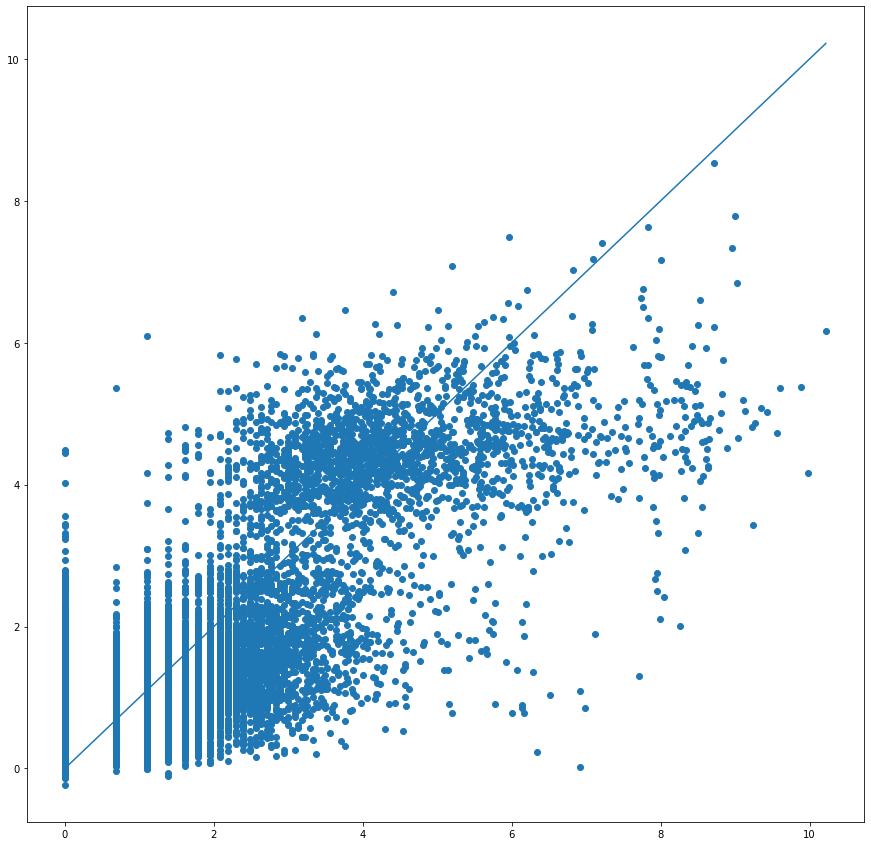

In [19]:
plt.figure(figsize=(15,15))
plt.scatter(y,y_oof)
plt.plot(a,a)


In [17]:
y_test_sub =  np.mean(y_test,axis=0)
y_test_sub = np.expm1(y_test_sub)
sub = pd.read_csv(SUB_PATH)
sub["likes"] = y_test_sub
sub.loc[sub.likes <= 0,"likes"] = 0
sub.to_csv(SAVE_TEST_SUB_PATH,index=False)